In [3]:
import qutip as qt
from qutip import about
from qutip_qip.operations import gate_sequence_product
from qutip_qip.circuit import QubitCircuit

In [4]:
q = QubitCircuit(3, reverse_states=False)
q.add_gate("TOFFOLI", controls=[0,2], targets=[1])
q.add_gate("CNOT", controls=[0], targets=[1])

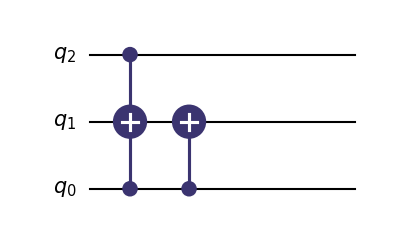

In [5]:
q.draw()

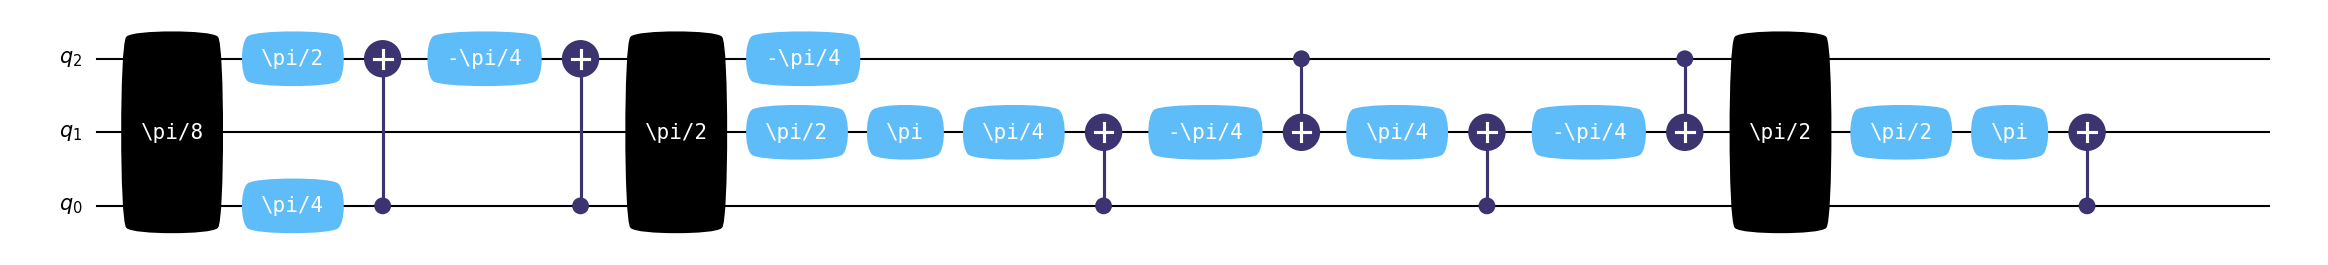

In [6]:
U = gate_sequence_product(q.propagators())

U.tidyup()

q2=q.resolve_gates()
q2.draw()

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import basis, fidelity, sigmax, sigmay, sigmaz, tensor, about
from qutip_qip.circuit import QubitCircuit
from qutip_qip.compiler import GateCompiler, Instruction, SpinChainCompiler
from qutip_qip.device import Model, ModelProcessor
from qutip_qip.noise import Noise
import qutip_qip

In [8]:
class MyModel(Model):
    def __init__(
        self, num_qubits, dims=None, h_x=1.0, h_z=1.0, g=0.1, t1=None, t2=None
    ):
        super().__init__(num_qubits, dims=dims)
        self.params = {
            "sz": [h_z] * num_qubits,
            "sx": [h_x] * num_qubits,
            "g": [g] * num_qubits,
            #  Will be accessed by the noise module.
            "t1": t1,
            "t2": t2,
        }
        # Control Hamiltonians
        _two_qubit_operator = tensor([sigmax(), sigmax()]) + tensor(
            [sigmay(), sigmay()]
        )
        self.controls = {}
        self.controls.update(
            {f"sx{n}": (2 * np.pi * sigmax(), n) for n in range(num_qubits)}
        )
        self.controls.update(
            {f"sz{n}": (2 * np.pi * sigmaz(), n) for n in range(num_qubits)}
        ),
        self.controls.update(
            {
                f"g{n}": (2 * np.pi * _two_qubit_operator, [n, n + 1])
                for n in range(num_qubits - 1)
            }
        ),

    def get_control(self, label):
        """
        The mandatory method. It Returns a pair of Qobj and int representing
        the control Hamiltonian and the target qubit.
        """
        return self.controls[label]

    def get_control_labels(self):
        """
        It returns all the labels of availble controls.
        """
        return self.controls.keys()

    def get_control_latex(self):
        """
        The function returns a list of dictionaries, corresponding to the latex
        representation of each control. This is used in the plotting.
        Controls in each dictionary will be plotted in a different colour.
        See examples later in this notebook.
        """
        return [
            {f"sx{n}": r"$\sigma_x^%d$" % n for n in range(num_qubits)},
            {f"sy{n}": r"$\sigma_z^%d$" % n for n in range(num_qubits)},
            {f"g{n}": r"$g_{%d}$" % (n) for n in range(num_qubits - 1)},
        ]

In [9]:
class MyCompiler(GateCompiler):  # compiler class
    def __init__(self, num_qubits, params):
        super(MyCompiler, self).__init__(num_qubits, params=params)
        # pass our compiler function as a compiler for X gate.
        self.gate_compiler["X"] = self.single_qubit_compiler
        self.gate_compiler["Y"] = self.single_qubit_compiler
        self.args.update({"params": params})

    def single_qubit_compiler(self, gate, args):
        """
        Compiler for the X and Y gate.
        """
        targets = gate.targets
        if gate.name == "Z":
            pulse_prefix = "sz"
            pulse_strength = args["params"]["sz"][targets[0]]
        elif gate.name == "X":
            pulse_prefix = "sx"
            pulse_strength = args["params"]["sx"][targets[0]]
        coeff, tlist = self.generate_pulse_shape(
            "hann",  # Scipy Hann window
            100,  # 100 sampling point
            maximum=pulse_strength,
            area=(np.pi / 2)
            / (
                2 * np.pi
            ),  # 1/2 becuase we use sigmax as the operator instead of sigmax/2
        )
        pulse_info = [(pulse_prefix + str(targets[0]), coeff)]
        return [Instruction(gate, tlist, pulse_info)]

In [10]:
num_qubits = 2
processor = ModelProcessor(model=MyModel(num_qubits, h_x=1.0, h_z=1.0, g=0.1))

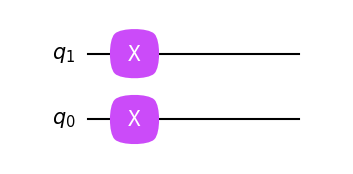

In [11]:
circuit = QubitCircuit(num_qubits)
circuit.add_gate("X", targets=1)
circuit.add_gate("X", targets=0)
circuit

In [12]:
gauss_compiler = MyCompiler(processor.num_qubits, processor.params)
processor = ModelProcessor(model=MyModel(num_qubits, h_x=1,h_z=1,g=.1,t1=300))

processor.pulse_mode = "continuous"
tlist, coeff = processor.load_circuit(circuit, compiler=gauss_compiler, schedule_mode=False)

result = processor.run_state(init_state=basis([2,2],[0,0]))

c:\Users\Tommy\OneDrive - Durham University\level 4 Project\L4 code directory\.venv\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


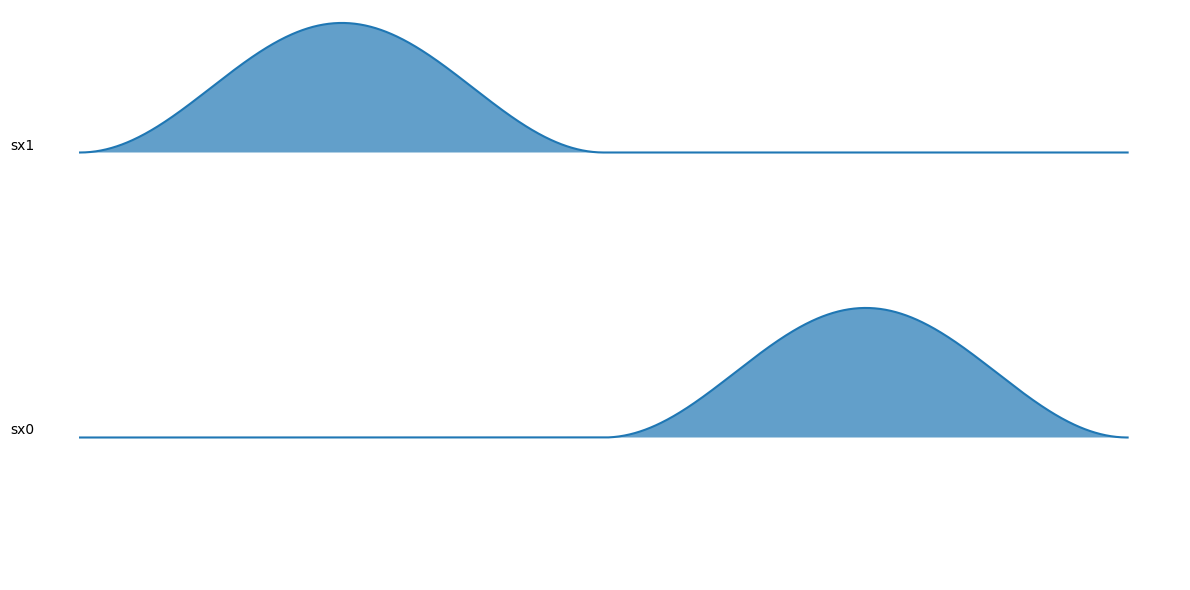

In [13]:
processor.plot_pulses(use_control_latex=False)
plt.show()

In [14]:
print(basis([3,3],[2,2]))

Quantum object: dims=[[3, 3], [1]], shape=(9, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]


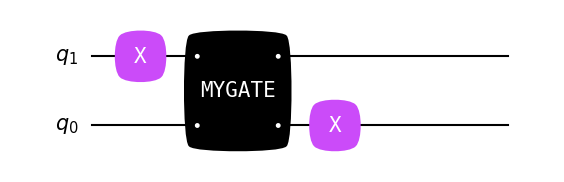

In [15]:
# define own gate
def mygate(theta=None):
    from qutip_qip.operations import molmer_sorensen

    return molmer_sorensen(theta, 2, targets=[0,1])

circuit = QubitCircuit(2)
circuit.user_gates = {"MYGATE": mygate} # assign name to gate

circuit.add_gate("X", targets=1)
circuit.add_gate("MYGATE", targets=[0, 1], arg_value=3 * np.pi / 2)
circuit.add_gate("X", targets=0)
circuit

In [16]:
circuit.run(basis([2, 2], [0, 1]))

Quantum object: dims=[[2, 2], [1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.        +0.j        ]
 [-0.53514018+0.46219584j]
 [-0.70710678+0.j        ]
 [ 0.        +0.j        ]]

get the compiler for this circuit operation

define a function for compiling gate

In [17]:
def mygate_compiler(gate, args):
    targets = gate.targets

    theta = gate.arg_value
    coeff1 = np.concatenate([np.linspace(0, 10, 50),
                            np.linspace(10, 0, 50), [0]]) /50
    coeff2 = np.concatenate([np.linspace(0, 10, 50),
                            np.linspace(10, 0, 50), [0]]) /50
    
    pulse_info = [("sx" + str(targets[0]), theta * coeff1),
                ("sx" + str(targets[1]), theta * coeff2),
                ]
    tlist = np.linspace(0, 1, len(coeff1))
    return[Instruction(gate, tlist, pulse_info)]

Instruction function gives control pulses to implement gate

Processor class accesses the control Hamiltonians to simulate the gate operation

Compiler returns Instruction from the circuit/gate

In [ ]:
gauss_compiler = MyCompiler(processor.num_qubits, processor.params)
processor = ModelProcessor(model=MyModel(num_qubits, h_x=1, h_z=1, g=.1, t1=300))

gauss_compiler.gate_compiler["MYGATE"] = mygate_compiler
# defining the compiler method for the custom gate

processor.pulse_mode = "continuous"
tlist, coeff = processor.load_circuit(circuit, compiler=gauss_compiler, schedule_mode=False)
processor.plot_pulses()
plt.show()

ValueError: Unsupported gate MYGATE


# Customising noise

Control elements stored as as a list of `Pulse` objects in processor

Idea pulse, control noise part, decoherence part

Systematic noise - saved under `Pulse` representation labelled `"system"` 